Add user to dataset

In [15]:
import numpy as np
import cv2
import os
import os.path

faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)
cap.set(3,640) # set Width
cap.set(4,480) # set Height
# For each person, enter one numeric face id
user_name = input('\n enter user name end press <return> ==>  ')
print(os.getcwd())
directory = 'dataset/' + user_name
isExist = os.path.exists(directory)

if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(directory)
print("\n [INFO] Initializing face capture. Look the camera and wait ...")

images_in_dir_count = len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory + '/' + name))])

count = 0
while True:
    ret, img = cap.read()
    #img = cv2.flip(img, -1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(
        gray,     
        scaleFactor=1.2,
        minNeighbors=10,     
        minSize=(20, 20)
    )
    for (x,y,w,h) in faces:
        count += 1
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]  
        
        # Save the captured image into the datasets folder
        cv2.imwrite(directory + '/' + str(count + images_in_dir_count) + ".jpg", gray[y:y+h,x:x+w])
    cv2.imshow('video',img)
    k = cv2.waitKey(30) & 0xff 
    if k == 27: # press 'ESC' to quit
        break
    elif count >= 30: # Take 30 face sample and stop video
         break
cap.release()
cv2.destroyAllWindows()

c:\Users\Тетяна\Desktop\LNU Deep Learning
c:\Users\Тетяна\Desktop\LNU Deep Learning

 [INFO] Initializing face capture. Look the camera and wait ...


Face recognition library

In [12]:
import face_recognition
import cv2
import numpy as np
from PIL import Image
import os
import json

dataset_path = "dataset"


recognizer = cv2.face.LBPHFaceRecognizer_create()
detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
# function to get the images and label data
def getImagesAndLabels(path):
    
    known_face_encodings = []
    known_face_names = [] 
    for user_folder in os.listdir(dataset_path):
        user_folder_path = os.path.join(dataset_path, user_folder)
        if os.path.isdir(user_folder_path):
            
            for image_file in os.listdir(user_folder_path):
                image_path = os.path.join(user_folder_path, image_file)

                if os.path.isfile(image_path):
                    print(image_path)
                    image = face_recognition.load_image_file(image_path)

                    # Find face locations in the image
                    #face_locations = face_recognition.face_locations(image)

                    # Encode faces in the image
                    face_encoding = face_recognition.face_encodings(image)#, face_locations)

                    #if face_encoding:
                        # If a face is found, add the encoding and corresponding label to the lists
                    known_face_encodings.append(face_encoding[0])
                    known_face_names.append(user_folder)
    return known_face_encodings, known_face_names
known_face_encodings, known_face_names = getImagesAndLabels(dataset_path)


dataset\liuda\1.jpg
dataset\liuda\10.jpg
dataset\liuda\11.jpg
dataset\liuda\12.jpg
dataset\liuda\13.jpg
dataset\liuda\14.jpg
dataset\liuda\15.jpg
dataset\liuda\16.jpg
dataset\liuda\17.jpg
dataset\liuda\18.jpg
dataset\liuda\19.jpg
dataset\liuda\2.jpg
dataset\liuda\20.jpg
dataset\liuda\21.jpg
dataset\liuda\22.jpg
dataset\liuda\23.jpg
dataset\liuda\24.jpg
dataset\liuda\25.jpg
dataset\liuda\26.jpg
dataset\liuda\27.jpg
dataset\liuda\28.jpg
dataset\liuda\29.jpg
dataset\liuda\3.jpg
dataset\liuda\30.jpg
dataset\liuda\31.jpg
dataset\liuda\32.jpg
dataset\liuda\33.jpg
dataset\liuda\34.jpg
dataset\liuda\35.jpg
dataset\liuda\36.jpg
dataset\liuda\37.jpg
dataset\liuda\38.jpg
dataset\liuda\39.jpg
dataset\liuda\4.jpg
dataset\liuda\40.jpg
dataset\liuda\41.jpg
dataset\liuda\42.jpg
dataset\liuda\43.jpg
dataset\liuda\44.jpg
dataset\liuda\45.jpg
dataset\liuda\46.jpg
dataset\liuda\47.jpg
dataset\liuda\48.jpg
dataset\liuda\49.jpg
dataset\liuda\5.jpg
dataset\liuda\50.jpg
dataset\liuda\51.jpg
dataset\liuda\52.j

In [28]:
import cv2
import numpy as np
import os 
import json

print(os.getcwd())

cascadePath = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascadePath)
font = cv2.FONT_HERSHEY_SIMPLEX
predicted_label = ""
# Initialize and start realtime video capture
cam = cv2.VideoCapture(0)
cam.set(3, 640) # set video widht
cam.set(4, 480) # set video height
# Define min window size to be recognized as a face
minW = 0.1*cam.get(3)
minH = 0.1*cam.get(4)
while True:
    ret, img =cam.read()
    #img = cv2.flip(img, -1) # Flip vertically
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale( 
        gray,
        scaleFactor = 1.2,
        minNeighbors = 10,
        minSize = (int(minW), int(minH)),
       )
    
    for(x,y,w,h) in faces:
        cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
        gray[y:y+h,x:x+w]
        unknown_face_encoding = face_recognition.face_encodings(cv2.cvtColor(gray[y:y+h,x:x+w], cv2.COLOR_GRAY2RGB))
        if len(unknown_face_encoding) > 0:
            # Compare the unknown face encoding with the stored encodings
            matches = face_recognition.compare_faces(known_face_encodings, unknown_face_encoding[0])
            face_distances = face_recognition.face_distance(known_face_encodings, unknown_face_encoding[0])
            best_match_index = np.argmin(face_distances)
            if matches[best_match_index]:
                predicted_label = known_face_names[best_match_index]
            else:
                predicted_label = "Unknown"
                
        
        cv2.putText(
                    img, 
                    str(predicted_label), 
                    (x+5,y-5), 
                    font, 
                    1, 
                    (255,255,255), 
                    2
                   )
     
    
    cv2.imshow('camera',img) 
    k = cv2.waitKey(10) & 0xff # Press 'ESC' for exiting video
    if k == 27:
        break
# Do a bit of cleanup
print("\n [INFO] Exiting Program and cleanup stuff")
cam.release()
cv2.destroyAllWindows()

c:\Users\Тетяна\Desktop\LNU Deep Learning


KeyboardInterrupt: 

Load dataset for training a model

In [ ]:
import cv2
import numpy as np
from PIL import Image
import os
import json

# Path for face image database
dataset_path = "dataset"

detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
# function to get the images and label data
def getImagesAndLabels(path):
    images = []
    user_names = []

    for user_folder in os.listdir(dataset_path):
        user_folder_path = os.path.join(dataset_path, user_folder)
        if os.path.isdir(user_folder_path):
            
            for image_file in os.listdir(user_folder_path):
                image_path = os.path.join(user_folder_path, image_file)

                if os.path.isfile(image_path):
                    print(image_path)

                    PIL_img = Image.open(image_path).convert('L') # grayscale
                    img_numpy = np.array(PIL_img,'uint8')
        

                    images.append(img_numpy)
                    user_names.append(user_folder)
    return images,user_names

def labels_to_int(labels):
    
    # Заповнюємо словник імен та його обернену версію
    class_to_number = {}
    number_to_class={}
    for number, class_name in enumerate(set(labels)):
        class_to_number[class_name] = number
        number_to_class[number] = class_name
    # Зберігаємо словники у файли
    with open('class_to_number.json', 'w') as file:
        json.dump(class_to_number, file)
    with open('number_to_class.json', 'w') as file:
        json.dump(number_to_class, file)

    # Тепер можна використовувати ці словники для перетворення назв класів в числа і навпаки
    numeric_labels = [class_to_number[class_name] for class_name in labels]
    print(numeric_labels)
    return numeric_labels

images,user_names = getImagesAndLabels(dataset_path)
numeric_classes = labels_to_int(user_names)


dataset\liuda\1.jpg
dataset\liuda\10.jpg
dataset\liuda\11.jpg
dataset\liuda\12.jpg
dataset\liuda\13.jpg
dataset\liuda\14.jpg
dataset\liuda\15.jpg
dataset\liuda\16.jpg
dataset\liuda\17.jpg
dataset\liuda\18.jpg
dataset\liuda\19.jpg
dataset\liuda\2.jpg
dataset\liuda\20.jpg
dataset\liuda\21.jpg
dataset\liuda\22.jpg
dataset\liuda\23.jpg
dataset\liuda\24.jpg
dataset\liuda\25.jpg
dataset\liuda\26.jpg
dataset\liuda\27.jpg
dataset\liuda\28.jpg
dataset\liuda\29.jpg
dataset\liuda\3.jpg
dataset\liuda\30.jpg
dataset\liuda\31.jpg
dataset\liuda\32.jpg
dataset\liuda\33.jpg
dataset\liuda\34.jpg
dataset\liuda\35.jpg
dataset\liuda\36.jpg
dataset\liuda\37.jpg
dataset\liuda\38.jpg
dataset\liuda\39.jpg
dataset\liuda\4.jpg
dataset\liuda\40.jpg
dataset\liuda\41.jpg
dataset\liuda\42.jpg
dataset\liuda\43.jpg
dataset\liuda\44.jpg
dataset\liuda\45.jpg
dataset\liuda\46.jpg
dataset\liuda\47.jpg
dataset\liuda\48.jpg
dataset\liuda\49.jpg
dataset\liuda\5.jpg
dataset\liuda\50.jpg
dataset\liuda\51.jpg
dataset\liuda\52.j

In [ ]:
images[0]

array([[139, 138, 138, ..., 136, 145, 144],
       [140, 141, 142, ..., 132, 141, 137],
       [138, 140, 142, ..., 128, 137, 136],
       ...,
       [ 45,  40,  37, ...,  62,  63,  61],
       [ 45,  40,  37, ...,  60,  63,  63],
       [ 42,  41,  40, ...,  55,  60,  61]], dtype=uint8)

Train model

In [ ]:
recognizer = cv2.face.LBPHFaceRecognizer_create()

print ("\n [INFO] Training faces. It will take a few seconds. Wait ...")
data = np.array( images)
recognizer.train(data, np.array(numeric_classes))##################################
# Save the model into trainer/trainer.yml
recognizer.write('trainer/trainer.yml') 

# Print the numer of faces trained and end program
print("\n [INFO] {0} faces trained. Exiting Program".format(len(np.unique(user_names))))


 [INFO] Training faces. It will take a few seconds. Wait ...


C:\Users\Тетяна\AppData\Local\Temp\ipykernel_4080\3202068442.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array( images)



 [INFO] 3 faces trained. Exiting Program


Test with trained model

In [18]:
import cv2
import numpy as np
import os 
import json

print(os.getcwd())
recognizer = cv2.face.LBPHFaceRecognizer_create()######################
recognizer.read('trainer/trainer.yml')#####################
with open('number_to_class.json', 'r') as file:
    loaded_number_to_class = json.load(file)
loaded_number_to_class = {int(key): value for key, value in loaded_number_to_class.items()}
id = 0###############################

cascadePath = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascadePath)
font = cv2.FONT_HERSHEY_SIMPLEX

# Initialize and start realtime video capture
cam = cv2.VideoCapture(0)
cam.set(3, 640) # set video widht
cam.set(4, 480) # set video height
# Define min window size to be recognized as a face
minW = 0.1*cam.get(3)
minH = 0.1*cam.get(4)
while True:
    ret, img =cam.read()
    #img = cv2.flip(img, -1) # Flip vertically
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale( 
        gray,
        scaleFactor = 1.2,
        minNeighbors = 10,
        minSize = (int(minW), int(minH)),
       )
    for(x,y,w,h) in faces:
        cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
        id, confidence = recognizer.predict(gray[y:y+h,x:x+w])#################
        
        # If confidence is less them 100 ==> "0" : perfect match 
        if (confidence < 100):
            id = loaded_number_to_class[id]
            confidence = "  {0}%".format(round(100 - confidence))
        else:
            id = "unknown"
            confidence = "  {0}%".format(round(100 - confidence))
        
        cv2.putText(
                    img, 
                    str(id), 
                    (x+5,y-5), 
                    font, 
                    1, 
                    (255,255,255), 
                    2
                   )
        cv2.putText(
                    img, 
                    str(confidence), 
                    (x+5,y+h-5), 
                    font, 
                    1, 
                    (255,255,0), 
                    1
                   )  
    
    cv2.imshow('camera',img) 
    k = cv2.waitKey(10) & 0xff # Press 'ESC' for exiting video
    if k == 27:
        break
# Do a bit of cleanup
print("\n [INFO] Exiting Program and cleanup stuff")
cam.release()
cv2.destroyAllWindows()

c:\Users\Тетяна\Desktop\LNU Deep Learning

 [INFO] Exiting Program and cleanup stuff


In [16]:
print(loaded_number_to_class)
print(number_to_class)

{'0': 'liuda', '1': 'vitalik', '2': 'tetiana'}
{0: 'liuda', 1: 'vitalik', 2: 'tetiana'}


570, 570
[[[138 138 138]
  [138 138 138]
  [134 134 134]
  ...
  [141 141 141]
  [136 136 136]
  [131 131 131]]

 [[136 136 136]
  [138 138 138]
  [133 133 133]
  ...
  [138 138 138]
  [132 132 132]
  [130 130 130]]

 [[137 137 137]
  [139 139 139]
  [134 134 134]
  ...
  [138 138 138]
  [132 132 132]
  [130 130 130]]

 ...

 [[133 133 133]
  [134 134 134]
  [138 138 138]
  ...
  [153 153 153]
  [206 206 206]
  [228 228 228]]

 [[142 142 142]
  [145 145 145]
  [148 148 148]
  ...
  [148 148 148]
  [176 176 176]
  [207 207 207]]

 [[145 145 145]
  [144 144 144]
  [141 141 141]
  ...
  [108 108 108]
  [165 165 165]
  [150 150 150]]]


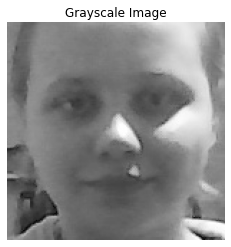

In [22]:
import matplotlib.pyplot as plt
print(str(len(images)) + ', ' + str( len(user_names)))
print(images[0])
plt.imshow(images[70], cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()

In [8]:
#images[0]
print(os.getcwd())


C:\Users\Тетяна
